In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import zipfile
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Concatenate, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, Sequential

import warnings
warnings.filterwarnings('ignore')

2024-03-28 06:56:20.081213: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 06:56:20.081338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 06:56:20.183262: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Displaying the input files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [4]:
working_dir = "/kaggle/working"
training_dir_zip = "/kaggle/input/dogs-vs-cats/train.zip"
testing_dir_zip = "/kaggle/input/dogs-vs-cats/test1.zip"

os.makedirs(working_dir, exist_ok=True)

with zipfile.ZipFile(training_dir_zip, 'r') as train_zip:
    train_zip.extractall(working_dir)
    
with zipfile.ZipFile(testing_dir_zip, 'r') as testing_zip:
    testing_zip.extractall(working_dir)
    
training_dir = "/kaggle/working/train"
testing_dir = "/kaggle/working/test1"

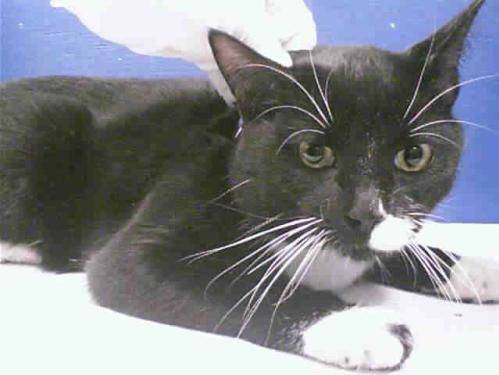

Images have different sizes


In [5]:
images = os.listdir(training_dir)
prev = Image.open(os.path.join(training_dir, images[0]))

display(prev)

for image in images[1:]:
    current = Image.open(os.path.join(training_dir, image))
    if prev.size != current.size:
        print('Images have different sizes')
        break
    prev = current   

In [6]:
cats_train_dir = os.path.join(training_dir, 'cats')
dogs_train_dir = os.path.join(training_dir, 'dogs')

validation_dir = '/kaggle/working/validation'

cats_validate_dir = os.path.join(validation_dir, 'cats')
dogs_validate_dir = os.path.join(validation_dir, 'dogs')

os.makedirs(cats_train_dir, exist_ok=True)
os.makedirs(dogs_train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(cats_validate_dir, exist_ok=True)
os.makedirs(dogs_validate_dir, exist_ok=True)

In [7]:
for image in images[:20000]:
    animal_type = image.split('.')[0]
    source_file = os.path.join(training_dir, image)
    
    match animal_type:
        case 'cat':
            destination_file = os.path.join(cats_train_dir, image)
            
        case 'dog':
            destination_file = os.path.join(dogs_train_dir, image)
            
    os.rename(source_file, destination_file)

In [8]:
for image in images[20000:]:
    animal_type = image.split('.')[0]
    source_file = os.path.join(training_dir, image)
    
    match animal_type:
        case 'cat':
            destination_file = os.path.join(cats_validate_dir, image)
            
        case 'dog':
            destination_file = os.path.join(dogs_validate_dir, image)
            
    os.rename(source_file, destination_file)

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(64, 64),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(64,64),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [10]:
train_datagen

In [11]:
'''# Part 1 - Data Preprocessing

# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('/kaggle/working/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/kaggle/working/test1',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')'''

"# Part 1 - Data Preprocessing\n\n# Preprocessing the Training set\ntrain_datagen = ImageDataGenerator(rescale = 1./255,\n                                   shear_range = 0.2,\n                                   zoom_range = 0.2,\n                                   horizontal_flip = True)\n\ntraining_set = train_datagen.flow_from_directory('/kaggle/working/train',\n                                                 target_size = (64, 64),\n                                                 batch_size = 32,\n                                                 class_mode = 'binary')\n# Preprocessing the Test set\ntest_datagen = ImageDataGenerator(rescale = 1./255)\ntest_set = test_datagen.flow_from_directory('/kaggle/working/test1',\n                                            target_size = (64, 64),\n                                            batch_size = 32,\n                                            class_mode = 'binary')"

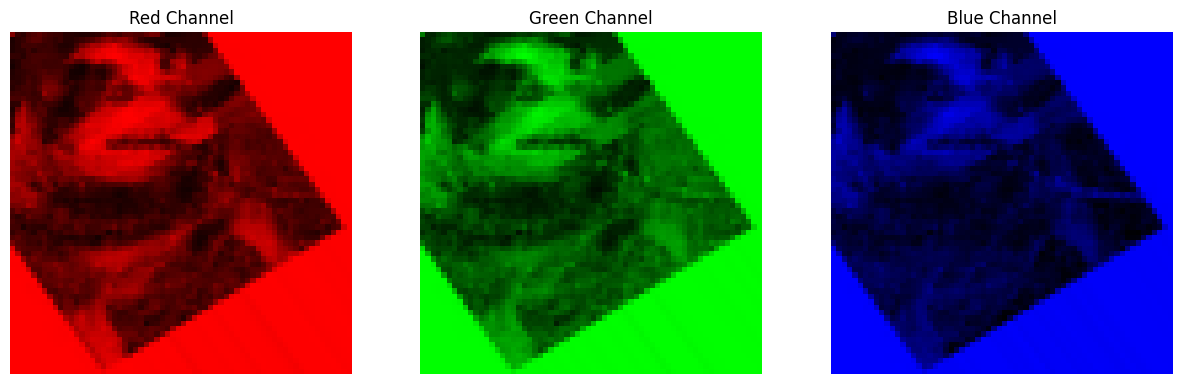

In [12]:
for x, y in train_generator:
    img = x[0]
    red_channel = img[:,:,0]
    green_channel = img[:,:,1]
    blue_channel = img[:,:,2]
    
    plt.figure(figsize=(15,5))
    
    red_image=np.stack([red_channel, np.zeros_like(red_channel), np.zeros_like(red_channel)], axis=-1)
    green_image=np.stack([np.zeros_like(green_channel), green_channel, np.zeros_like(green_channel)], axis=-1)
    blue_image=np.stack([np.zeros_like(blue_channel), np.zeros_like(blue_channel), blue_channel], axis=-1)
                        
    plt.subplot(1,3,1)
    plt.imshow(red_image)
    plt.title('Red Channel')
    plt.axis('off')
    
    plt.subplot(1,3,2)
    plt.imshow(green_image)
    plt.title('Green Channel')
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(blue_image)
    plt.title('Blue Channel')
    plt.axis('off')

    break

In [13]:
# Part 2 - Building the CNN
# Initialising the CNN
cnn = tf.keras.models.Sequential()

# Step 1 - Convolution
cnn.add(tf.keras.layers.Conv2D(filters=32,padding="same",kernel_size=3, activation='relu', strides=2, input_shape=[64, 64, 3]))

# Step 2 - Pooling
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32,padding='same',kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Step 3 - Flattening
cnn.add(tf.keras.layers.Flatten())

# Step 4 - Full Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Step 5 - Output Layer
#cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
## For Binary Classification
cnn.add(Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear'))

In [14]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,545 (1.04 MB)

 Trainable params: 272,545 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Part 3 - Training the CNN

# Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'hinge', metrics = ['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
r=cnn.fit(x = train_generator, validation_data = validation_generator, epochs = 10)

Epoch 1/10
  4/625 ━━━━━━━━━━━━━━━━━━━━ 34s 55ms/step - accuracy: 0.4512 - loss: 1.0407

I0000 00:00:1711609011.158394      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711609011.175682      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 91ms/step - accuracy: 0.5437 - loss: 0.9297 - val_accuracy: 0.6816 - val_loss: 0.6744
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.6518 - loss: 0.7412 - val_accuracy: 0.6784 - val_loss: 0.6372
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.6617 - loss: 0.7183 - val_accuracy: 0.6836 - val_loss: 0.8277
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.6823 - loss: 0.6770 - val_accuracy: 0.7368 - val_loss: 0.6345
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.6865 - loss: 0.6712 - val_accuracy: 0.7564 - val_loss: 0.5795
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.6993 - loss: 0.6517 - val_accuracy: 0.7582 - val_loss: 0.5634
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.7057 - loss: 0.6310 - val_accuracy: 0.7530 - val_loss: 0.6117
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.7092 - loss: 0.6227 - val_accurac

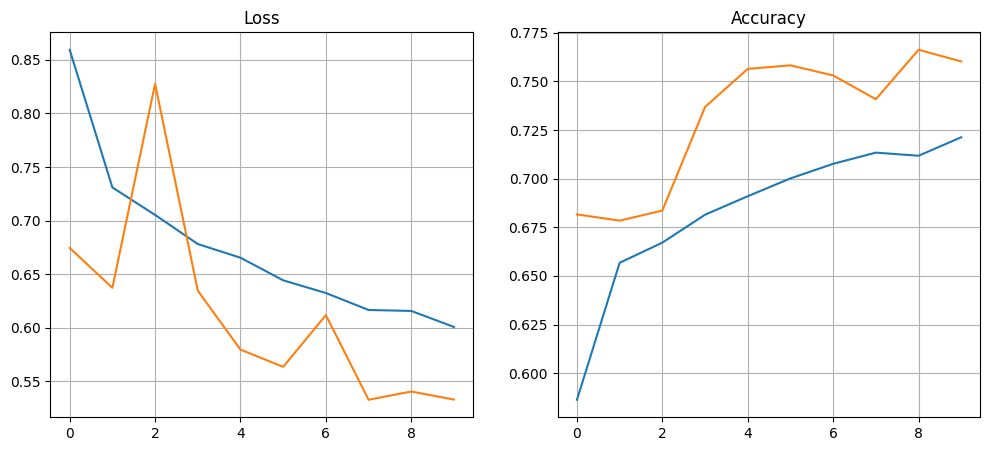

In [16]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Loss')

plt.grid(True)

plt.subplot(1,2,2)
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('Accuracy')
plt.grid(True)